# **Named Entity recognition with spaCy**
---
    Course - B9DA109: Machine Learning and Pattern Recognition
---
    Group Members:
    20066423 - Anish Rao
    20054683 - Adithya Durgapu
    20058721 - Phani Sri Pavansai Sharath Chandra Chavali Venkata
---
### Dataset - [BioCreative-V CDR Corpus](https://github.com/JHnlp/BioCreative-V-CDR-Corpus)
---
### Colab link - [Google Colab](https://colab.research.google.com/drive/1jZwS7BOgqTvIzTqZh6f3x4iyR4-mKNLQ?usp=sharing)
---

## **Project Overview: Goal & Approach**

**Goal**:
> Our aim is to build a Named Entity Recognition (NER) system for identifying chemical and disease entities in biomedical text By combining rule-based techniques with active learning, we want to achieve good performance while keeping manual annotation to a minimum.

**Approach**:
> - Build a custom NLP pipeline using spaCy
- Use spaCy’s rule-based matching to create weak labels for for chemical and disease entities
- Apply uncertainty sampling to identify uncertain predictions, prioritizing them for manual annotation to improve model accuracy.
- Train a blank spaCy model iteratively using minibatch training, refining entity recognition over multiple active learning cycles.
- Evaluate model performance using:
 - Precision (how many detected entities are correct?)
 - Recall (how many actual entities were successfully identified?)
 - F1-score (the harmonic mean of precision and recall, ensuring balanced performance evaluation).

# **Importing Libraries & Initializing spaCy Model**

In [ ]:
# !pip install -U spacy

In [8]:
import spacy
from spacy.matcher import Matcher
from spacy.training import Example
import random
import warnings
import spacy.util
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

# load blank spacy model
nlp = spacy.blank("en")

warnings.filterwarnings('ignore')

# **Loading & Parsing PubTator Datag**

In [6]:
def parse_data(file_path, remove_gold=False):
    """
    Parses a PubTator file to extract the combined text (title + abstract)
    Optionally, the entity annotations.

    Args:
        file_path (str): Path to the PubTator file.
        remove_gold (bool): If True, ignore entity annotations
                            If False, keep entity annotations

    Returns:
        list: A list of dictionaries, each containing:
              -> "text": The combined document text.
              -> "entities": A list of tuples (start, end, label)
                            if remove_gold is False, otherwise an empty list.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()

    docs = []
    current = {"text": "", "entities": []}

    for line in data.split("\n"):
        if line.startswith("#####"):
            continue
        if "|t|" in line:
            # Title
            current["text"] = line.split("|t|")[-1].strip()
        elif "|a|" in line:
            # Append Abstract
            current["text"] += " " + line.split("|a|")[-1].strip()
        elif "\t" in line and not remove_gold:
            # Parse annotations only for Test set.
            parts = line.split("\t")
            if len(parts) >= 5:
                try:
                    start, end, label = int(parts[1]), int(parts[2]), parts[4]
                except ValueError:
                    continue
                current["entities"].append((start, end, label))
        elif line.strip() == "" and current["text"]:
            # End of a document; add it to our list.
            docs.append(current)
            current = {"text": "", "entities": []}

    if current["text"]:
        docs.append(current)
    return docs

train_path = "CDR_TrainingSet.PubTator.txt"
dev_path   = "CDR_DevelopmentSet.PubTator.txt"
test_path  = "CDR_TestSet.PubTator.txt"

# Parse the files:
train = parse_data(train_path, remove_gold=True)
dev = parse_data(dev_path, remove_gold=True)
test = parse_data(test_path, remove_gold=False)

train_dev = train + dev

In [ ]:
# Test prints: print a sample from the parsed datasets.
print("Combined Train+Dev Sample:")
if train_dev:
    print(train_dev[0])
else:
    print("No documents found.")
print("=" * 40)
print("Test Set Sample (with gold annotations):")
if test:
    print(test[0])
else:
    print("No documents found.")

Combined Train+Dev Sample:
{'text': 'Naloxone reverses the antihypertensive effect of clonidine. In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to 20 micrograms/kg, was inhibited or reversed by nalozone, 0.2 to 2 mg/kg. The hypotensive effect of 100 mg/kg alpha-methyldopa was also partially reversed by naloxone. Naloxone alone did not affect either blood pressure or heart rate. In brain membranes from spontaneously hypertensive rats clonidine, 10(-8) to 10(-5) M, did not influence stereoselective binding of [3H]-naloxone (8 nM), and naloxone, 10(-8) to 10(-4) M, did not influence clonidine-suppressible binding of [3H]-dihydroergocryptine (1 nM). These findings indicate that in spontaneously hypertensive rats the effects of central alpha-adrenoceptor stimulation involve activation of opiate receptors. As naloxone and clonidine do not appear to interact with the same receptor site, the observed functio

# **Exploratory Data Analysis (EDA)**
for Train + Dev sets

In [10]:
train_eda = parse_data(train_path, remove_gold=False)
dev_eda = parse_data(dev_path, remove_gold=False)
combined_eda_set = train_eda + dev_eda
num_docs = len(combined_eda_set)
print("Total number of documents:", num_docs)

# Number of characters per document
doc_lengths = [len(doc["text"]) for doc in combined_eda_set]
avg_length = sum(doc_lengths) / num_docs
print("Average document length (characters):", round(avg_length, 2))

# unique labels and their counts
label_counter = Counter(entity[2] for doc in combined_eda_set for entity in doc["entities"])
print("Unique Entity Labels and Their Counts:")
for label, count in label_counter.items():
    print(f"{label}: {count}")

# Number of entities per document
num_entities = [len(doc["entities"]) for doc in combined_eda_set]
avg_entities = sum(num_entities) / num_docs
print("Average number of entities per document:", round(avg_entities, 2))

Total number of documents: 1000
Average document length (characters): 1299.7
Unique Entity Labels and Their Counts:
Chemical: 10550
Disease: 8426
Average number of entities per document: 18.98


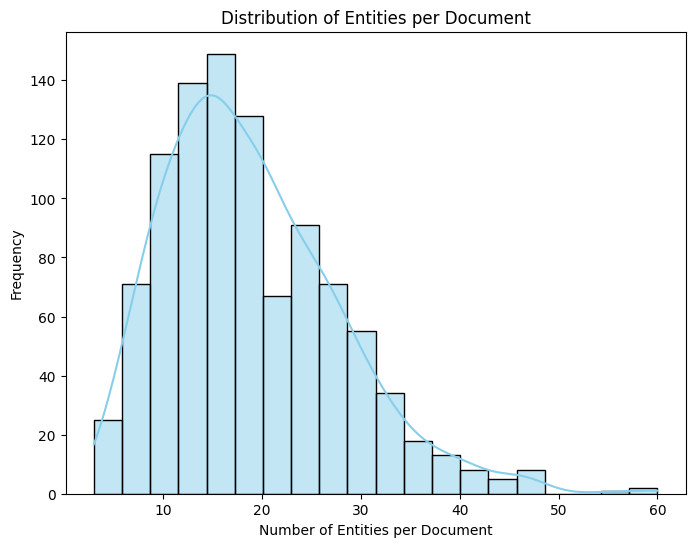

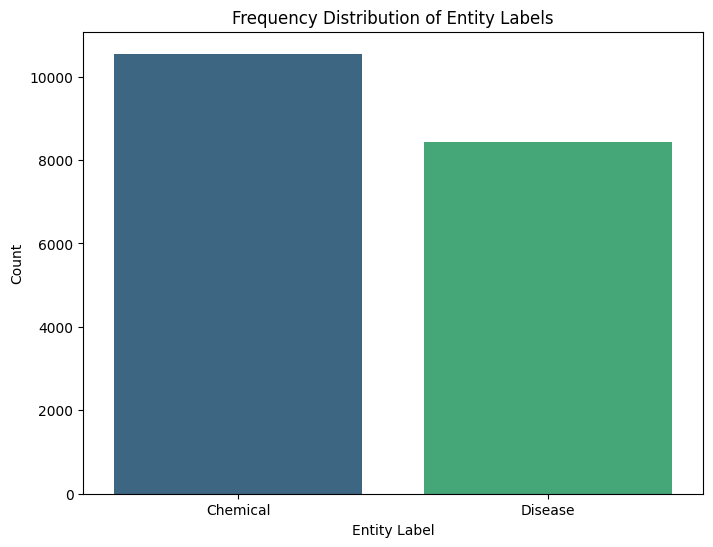

In [11]:
# Distribution of entities per document
plt.figure(figsize=(8, 6))
sns.histplot(num_entities, bins=20, kde=True, color="skyblue")
plt.xlabel("Number of Entities per Document")
plt.ylabel("Frequency")
plt.title("Distribution of Entities per Document")
plt.show()

# Bar chart for entity label frequencies
label_counts = {}
for doc in combined_eda_set:
    for ent in doc["entities"]:
        label = ent[2]
        label_counts[label] = label_counts.get(label, 0) + 1
labels = list(label_counts.keys())
counts = list(label_counts.values())
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts, palette="viridis")
plt.xlabel("Entity Label")
plt.ylabel("Count")
plt.title("Frequency Distribution of Entity Labels")
plt.show()

# **Rule-Based Matching for Entity Annotation**

In [ ]:
matcher = Matcher(nlp.vocab)

chem_patterns = [
    [{"LOWER": {"REGEX": "^[a-z0-9-]+(ol|ine|ide|one|ate|amine|azole|vir|dopa|mab|statin|pril|sartan|rin)$"}}],
    [{"LOWER": {"REGEX": "^(?:cyclo|benz|ethyl|methyl|hydro)[a-z0-9-]*$"}}],
    [{"LOWER": {"IN": ["insulin", "penicillin"]}}],
    [
        {"LOWER": {"REGEX": "^[a-z0-9-]+$"}, "OP": "+"},
        {"LOWER": "acid"}
    ],
    [
        {"LOWER": {"REGEX": "^[a-z0-9-]+$"}},
        {"LOWER": {"REGEX": "^(chloride|sulfate|sulphate|oxide|nitrate)$"}}
    ],
    [
        {"LOWER": {"REGEX": "^[a-z0-9-]+$"}, "OP": "+"},
        {"LOWER": {"REGEX": "^(inhibitor|inhibitors|blocker|blockers|antagonist|agonist)$"}}
    ]
]

disease_patterns = [
    [{"LOWER": {"REGEX": "^[a-z]+(itis|osis|emia|pathy|oma|algia|penia|dystrophy|sclerosis|necrosis|lepsy)$"}}],
    [{"LOWER": {"IN": [
        "hypertensive", "hypotensive", "cancer", "tumor", "tumour",
        "diabetes", "malaria", "syndrome", "delirium", "migraine"
    ]}}],
    [{"TEXT": {"REGEX": ".*opathy$"}}],
    [
        {"LOWER": {"REGEX": "^[a-z]+$"}, "OP": "+"},
        {"LOWER": {"REGEX": "^(disease|syndrome|cancer|tumor|tumour)$"}}
    ],
    [
        {"LOWER": {"REGEX": "^[a-z]+$"}},
        {"LOWER": "'s", "OP": "?"},
        {"LOWER": {"REGEX": "^(disease|syndrome)$"}}
    ],
    [{"TEXT": {"REGEX": "^cardiac$"}}, {"TEXT": {"REGEX": "^(arrest|asystole)$"}}],
    [{"TEXT": {"REGEX": "^heart$"}}, {"TEXT": {"REGEX": "^attack$"}}],
    [{"TEXT": {"REGEX": "^myocardial$"}}, {"TEXT": {"REGEX": "^infarction$"}}],
    [{"LOWER": {"IN": [
        "dystonia", "dyskinesia", "neuropathy", "fasciculation", "fasciculations",
        "hypertension", "myocardial infarction", "chronic renal failure", "crohn's disease",
        "infection", "fever", "headache", "inflammation", "stroke", "sepsis", "anemia"
    ]}}],
    [
        {"LOWER": {"REGEX": "^(acute|chronic|severe|idiopathic)$"}, "OP": "?"},
        {"LOWER": {"IN": ["renal", "cardiac", "pulmonary", "neuromuscular", "auditory", "visual"]}, "OP": "?"},
        {"LOWER": {"IN": ["failure", "injury", "deficiency", "dysfunction", "toxicity", "hypertension", "hypotension", "dystonia", "dyskinesia", "disorder"]}}
    ],
    [{"LOWER": {"REGEX": "^(neuro|cardio|hepato|nephro|pneumo|encephal)[a-z]+$"}}],
]

matcher.add("DISEASE", disease_patterns)
matcher.add("CHEMICAL", chem_patterns)

def annotate_docs_with_rules(docs):
    """
    Applies our rule-based matcher to each document to generate weak labels

    Args:
        docs (list): List of document dictionaries

    Returns:
        list: List of document dictionaries with an added key [auto_entities]
              with a list of weak entity annotations as tuples (start, end, label).
    """
    annotated_docs = []
    for doc in docs:
        text = doc["text"]
        spacy_doc = nlp(text)
        matches = matcher(spacy_doc)
        auto_entities = []
        for match_id, start, end in matches:
            span = spacy_doc[start:end]
            label = nlp.vocab.strings[match_id].title()
            auto_entities.append((span.start_char, span.end_char, label))
        new_doc = doc.copy()
        new_doc["auto_entities"] = auto_entities
        annotated_docs.append(new_doc)
    return annotated_docs

# We use a subset of the total data
seed_size = int(0.7 * len(train_dev))
seed_docs = train_dev[:seed_size]

# Apply the rule-based matcher
annotated_seed_docs = annotate_docs_with_rules(seed_docs)

In [ ]:
# Test print: print sample annotated documents.
print("\nSample Annotated Documents from Seed Set:")
num_samples = min(2, len(annotated_seed_docs))
for i in range(num_samples):
    sample = annotated_seed_docs[i]
    print("=" * 40)
    print(f"Document {i+1}:")
    print("Text:", sample["text"])
    print("Auto Entities:", sample.get("auto_entities", []))



Sample Annotated Documents from Seed Set:
Document 1:
Text: Naloxone reverses the antihypertensive effect of clonidine. In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to 20 micrograms/kg, was inhibited or reversed by nalozone, 0.2 to 2 mg/kg. The hypotensive effect of 100 mg/kg alpha-methyldopa was also partially reversed by naloxone. Naloxone alone did not affect either blood pressure or heart rate. In brain membranes from spontaneously hypertensive rats clonidine, 10(-8) to 10(-5) M, did not influence stereoselective binding of [3H]-naloxone (8 nM), and naloxone, 10(-8) to 10(-4) M, did not influence clonidine-suppressible binding of [3H]-dihydroergocryptine (1 nM). These findings indicate that in spontaneously hypertensive rats the effects of central alpha-adrenoceptor stimulation involve activation of opiate receptors. As naloxone and clonidine do not appear to interact with the same receptor si

# **NER Model training method**

In [ ]:
def train_ner_model(model, data, n_iter):
    """
    Trains a blank NER model using spaCy with the given data.

    Args:
        model: The blank spaCy model.
        data: List of training examples (dictionaries with "text" and "auto_entities").
        n_iter: Number of training iterations/Epochs.

    Returns:
        None
    """
    # Add NER component if not present.
    if "ner" not in model.pipe_names:
        ner = model.add_pipe("ner", last=True)
    else:
        ner = model.get_pipe("ner")

    # Add weak labels from the training data.
    for doc_data in data:
        ents = doc_data.get("auto_entities", [])
        for ent in ents:
            label = ent[2]
            try:
                ner.add_label(label)
            except Exception:
                pass

    # Prepare training examples.
    training_examples = []
    for doc_data in data:
        text = doc_data["text"]
        raw_ents = doc_data.get("auto_entities", [])
        doc = model.make_doc(text)
        spans = []
        # Convert entities to Span objects.
        for ent in raw_ents:
            span = doc.char_span(ent[0], ent[1], label=ent[2])
            if span is not None:
                spans.append(span)
        #remove overlapping spans.
        filtered_spans = spacy.util.filter_spans(spans)
        # Convert filtered spans back to the (start, end, label) format.
        annotations = {"entities": [(span.start_char, span.end_char, span.label_) for span in filtered_spans]}
        # Only add example if there's at least one entity.
        if annotations["entities"]:
            example = Example.from_dict(doc, annotations)
            training_examples.append(example)

    # Initialize optimizer.
    optimizer = model.begin_training()
    for itn in range(n_iter):
        random.shuffle(training_examples)
        losses = {}
        batches = spacy.util.minibatch(training_examples, size=16)
        for batch in batches:
            model.update(batch, drop=0.2, sgd=optimizer, losses=losses)
        print(f"Iteration {itn+1}: Loss = {losses.get('ner', 0):.4f}")
    print("\n==Model Training Completed==")


# **Active Learning with Uncertainty Sampling**

In [ ]:
def uncertainty_sampling(model, docs, n_samples, length_constant=200):
    """
    Selects n_samples documents based on model uncertainty.

    Args:
        model: The spaCy model.
        docs: List of document dictionaries (each with a 'text' key).
        n_samples: Number of documents to select.
        length_constant: Constant to scale uncertainty based on document length.

    Returns:
        List of document texts with the highest uncertainty.
    """
    scores = []
    for doc in docs:
        text = doc["text"]
        spacy_doc = model(text)
        confidences = [ent._.confidence for ent in spacy_doc.ents
                       if hasattr(ent._, "confidence")]
        if confidences:
            uncertainty = 1 - max(confidences)
        else:
            uncertainty = len(text) / (len(text) + length_constant)
        scores.append(uncertainty)

    indices = np.argsort(scores)[-n_samples:]
    return [docs[i]["text"] for i in indices]

def manual_annotation(text):
    """
    Simulates manual annotation by reapplying the rule-based matcher.

    Args:
        text: The input text.

    Returns:
        list: List of dictionaries with "start", "end", "label".
    """
    doc = nlp(text)
    matches = matcher(doc)
    ann = []
    for match_id, start, end in matches:
        span = doc[start:end]
        label = nlp.vocab.strings[match_id].title()
        ann.append({"start": span.start_char, "end": span.end_char, "label": label})
    return ann

def active_learning_loop(model, labeled_data, full_data, iterations=3, n_samples=5):
    """
    Simple active learning loop to iteratively update the labeled dataset
    and retrain the model.

    Args:
        model: The spaCy model.
        labeled_data: The initial labeled set
        full_data: The complete set of documents
        optimizer: The optimizer.
        iterations: Number of active learning iterations.
        n_samples: Number of uncertain samples to select per iteration.

    Returns:
        None
    """
    for i in range(iterations):
        print(f"\n=== Active Learning Iteration {i+1} ===")
        # Exclude documents already in labeled_data.
        already_labeled = {doc["text"] for doc in labeled_data}
        candidates = [doc for doc in full_data if doc["text"] not in already_labeled]

        # Use uncertainty sampling on remaining candidates.
        # selected_texts = uncertainty_sampling(model, candidates, n_samples)
        selected_texts = uncertainty_sampling(model, candidates, n_samples)
        print("Selected uncertain samples for annotation:")
        for text in selected_texts:
            print("  -", text[:100] + "...")

        # manual annotation on selected samples.
        new_annotations = []
        for doc in candidates:
            if doc["text"] in selected_texts:
                anns = manual_annotation(doc["text"])
                new_annotations.append({
                    "text": doc["text"],
                    "entities": [(ann["start"], ann["end"], ann["label"]) for ann in anns]
                })

        # Add the newly annotated examples to the labeled set.
        labeled_data.extend(new_annotations)
        print(f"New annotations added. Total labeled data size: {len(labeled_data)}")

        # Retrain the model on the updated labeled set.
        train_ner_model(model, labeled_data, n_iter=10)
        model.to_disk(f"model_iter_{i+1}")
        print(f"\nFinished Active Learning Iteration {i+1}")

    print("\nActive Learning Loop Completed")

## **Executing Active Learning Training**

In [ ]:
nlp.initialize()
active_learning_loop(nlp, annotated_seed_docs, train_dev, iterations=7, n_samples=25)


=== Active Learning Iteration 1 ===
Selected uncertain samples for annotation:
  - Association of nitric oxide production and apoptosis in a model of experimental nephropathy. BACKGRO...
  - Absence of acute cerebral vasoconstriction after cocaine-associated subarachnoid hemorrhage. INTRODU...
  - Chemotherapy of advanced inoperable non-small cell lung cancer with paclitaxel: a phase II trial. Pa...
  - Reduced cardiotoxicity and preserved antitumor efficacy of liposome-encapsulated doxorubicin and cyc...
  - Neuroactive steroids protect against pilocarpine- and kainic acid-induced limbic seizures and status...
  - Longitudinal assessment of air conduction audiograms in a phase III clinical trial of difluoromethyl...
  - Steroid structure and pharmacological properties determine the anti-amnesic effects of pregnenolone ...
  - Dexrazoxane protects against myelosuppression from the DNA cleavage-enhancing drugs etoposide and da...
  - Iatrogenic risks of endometrial carcinoma after trea

# **Evaluating the NER Model Performance**

In [ ]:
def evaluate_model(model, test_data):
    """
    Evaluates the trained NER model on test data using micro-averaged metrics.

    Args:
        model: The trained spaCy model.
        test_data: List of test document dictionaries with "text" and "entities".

    Returns:
        tuple: (Precision, Recall, F1-score)
    """
    y_true, y_pred = [], []
    for doc_data in test_data:
        text = doc_data["text"]
        gold = set(doc_data["entities"])
        doc = model(text)
        pred = set([(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents])

        all_labels = set([e[2] for e in gold]).union(set([e[2] for e in pred]))
        for label in all_labels:
            tp = len([e for e in gold if e in pred and e[2] == label])
            fp = len([e for e in pred if e not in gold and e[2] == label])
            fn = len([e for e in gold if e not in pred and e[2] == label])
            y_true.extend([label] * tp)
            y_pred.extend([label] * tp)
            y_true.extend([label] * fn)
            y_pred.extend(["O"] * fn)
            y_true.extend(["O"] * fp)
            y_pred.extend([label] * fp)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", labels=list(set(y_true) - {"O"})
    )
    print(f"\n=== Evaluation on Test Set ===")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return precision, recall, f1

# Execution

In [ ]:
# Prepare test data.
TEST_DATA = [{"text": doc["text"], "entities": doc["entities"]} for doc in test]
evaluate_model(nlp, TEST_DATA)


=== Evaluation on Test Set ===
Precision: 0.5819, Recall: 0.3580, F1-Score: 0.4433


(0.5819386909693455, 0.35803853603833213, 0.4433223933350164)